# Spatial Temporal Clustering of 2019 Teil Quake Tweets
---

In order to cluster the 2019 Teil Quake Tweets, we use ST-DBSCAN algorithm, a spatial-temporal clustering algorithm that is based on the DBSCAN algorithm augmented with a temporal parameter.

We have used the following implementation [ST-DBSCAN](https://github.com/eren-ck/st_dbscan).
> **Keywords** Data mining, Cluster analysis, Spatial–temporal data, Cluster visualization

### Importing libraries

In [1]:
import time
import warnings
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
from pathlib import Path
from cycler import cycler
import matplotlib.pyplot as plt
from st_dbscan import ST_DBSCAN
from prettytable import PrettyTable
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from py_module.utils import create_hulls, plot_space_time_cube, plot_hulls
from sklearn.preprocessing import MinMaxScaler

# Ignore warnings
warnings.filterwarnings('ignore')

# Set numpy print options
np.set_printoptions(precision=3, suppress=True)

# Set up matplotlib rcParams (runtime configuration) for plot color
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Use interactive matplotlib
%matplotlib widget

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Data wrangling

The preprocessing is done in the following steps:
- Read tweets from hdf file ;
- Remove tweets with no location information ;
- Constrain tweets to France area ;
- Order tweets by datetime ;
- Calculate cumulative time ;
- Create a new index ;
- Remove columns that are not needed ;
- Reproject coordinates to Lambert 93 ;
- Calculate projected coordinates ;
- Store x_m and y_m in separate numpy array for plotting ;
- Store cumulative_time_sec, x_m and y_m in a seperate numpy array for clustering ;
- Calculate pairwise distances ;
- Reorder columns.

In [2]:
# Read tweets from HDF5 file
data_dir = Path("../data")
tweets = pd.read_hdf(data_dir / "tweets.h5", "tweets")

# Remove tweets with no coordinates
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
        (tweets.latitude > 42.33278)
    &   (tweets.latitude < 51.08917)
    &   (tweets.longitude > -4.795556)
    &   (tweets.longitude < +8.230556)
]

# Order tweets by datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Convert datetime (in ns) to seconds, // (floor division) 10 ** 9 to get seconds
tweets['cumulative_time_sec'] = (tweets['createdAt'].values.astype(np.int64) // 10 ** 9)
# Convert ts in tweets to cumulative seconds
tweets['cumulative_time_sec'] -= tweets['cumulative_time_sec'].min()

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames', 'entity', 'wikidata'], inplace=True)
except:
    pass

# Reproject tweets to Lam-93
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Will be used for plotting (we can't plot normalized coordinates)
COORDS = tweets.loc[:, ['x_m','y_m']].values

# Calculate all pairwise terrain distances
dist = np.linalg.norm(COORDS[:, np.newaxis, :] - COORDS[np.newaxis, :, :], axis=-1)
dist.sort(axis=1)

# Scale coordinates to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tweets[['x_m', 'y_m']])

# ts, x_m_norm, y_m_norm
data = np.hstack((tweets['cumulative_time_sec'].values.reshape(-1, 1), scaled))

# Calculate all pairwise normalized distances
dist_norm = np.linalg.norm(data[:, np.newaxis, 1:] - data[np.newaxis, :, 1:], axis=-1)
dist_norm.sort(axis=1)

# Reorder columns
tweets = tweets[['text', 'x_m', 'y_m', 'createdAt', 'cumulative_time_sec', 'geometry']]

In [3]:
tweets.info()
tweets.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5193 entries, 1 to 5193
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   text                 5193 non-null   object             
 1   x_m                  5193 non-null   float64            
 2   y_m                  5193 non-null   float64            
 3   createdAt            5193 non-null   datetime64[ns, UTC]
 4   cumulative_time_sec  5193 non-null   int64              
 5   geometry             5193 non-null   geometry           
dtypes: datetime64[ns, UTC](1), float64(2), geometry(1), int64(1), object(1)
memory usage: 284.0+ KB


,text,x_m,y_m,createdAt,cumulative_time_sec,geometry
id,,,,,,
1,il y a 23 min #seisme 2.0 a frappé Arbaz (Sion...,1037421.834,6583455.288,2019-11-11 09:23:24+00:00,0,POINT (1037421.834 6583455.288)
2,Tremblement de terre à Lyon en ce moment !!!,843121.942,6519367.222,2019-11-11 10:53:46+00:00,5422,POINT (843121.942 6519367.222)
3,#Séisme ressenti à #Lyon à l'instant,843121.942,6519367.222,2019-11-11 10:53:56+00:00,5432,POINT (843121.942 6519367.222)
4,Tremblement de terre en Ardèche à l'instant,812290.663,6397402.763,2019-11-11 10:54:09+00:00,5445,POINT (812290.663 6397402.763)
5,Wait ! Y’a des tremblements de terre en France...,624015.535,6656012.010,2019-11-11 10:54:18+00:00,5454,POINT (624015.535 6656012.010)


### Spatial temporal clustering of Quake Tweets
#### Clustering with ST-DBSCAN

We'll launch clustering with parameters `eps1 = 90 km`, `eps2 = 10 min` et `min_samples = 22 tweets`.

In [4]:
# ST-DBSCAN Clustering
# Parameters
eps1 = 0.1 # Distance threshold
eps2 = 60*10 # Time threshold
min_samples = 22 # Minimum number of tweets in a cluster

# Calculate terrain distance threshold
eps1_terrain = (eps1 * dist[-1][-1]) / dist_norm[-1][-1]

# Run ST-DBSCAN
start = time.time()
st_dbscan = ST_DBSCAN(eps1 = eps1, eps2 = eps2, min_samples = min_samples, metric = 'euclidean').fit(data)
end = time.time()

# Label tweets with cluster id
tweets['cluster'] = st_dbscan.labels
tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
tweets.sort_index(inplace=True)
tweets.drop(columns=['cluster'], inplace=True)
tweets = tweets[['text', 'x_m', 'y_m', 'createdAt', 'cumulative_time_sec', 'geometry']]

# Print results

result = [
    ['eps1 (m)', 'eps2 (min)', 'MinPts', 'Time (s)', '# of clusters'],
    [f'{int(eps1_terrain):,}', int(eps2 / 60), min_samples, round(end - start, 2), len(set(st_dbscan.labels))]
]

table = PrettyTable(result[0])
table.add_row(result[1])
print(table)

+----------+------------+--------+----------+---------------+
| eps1 (m) | eps2 (min) | MinPts | Time (s) | # of clusters |
+----------+------------+--------+----------+---------------+
|  90,159  |     10     |   22   |   1.24   |       5       |
+----------+------------+--------+----------+---------------+


#### Convex hulls as Quake feeling areas

In order to assess the extent of the quake, we'll create a convex hull for each cluster.

In [5]:
# Create hulls
hulls = create_hulls(tweets, st_dbscan, COORDS)

# Remove tweets with no hull
hull_tweet_set = set(hulls.index)
no_hull_tweet_set = set(tweets.index.get_level_values(0)) - set(hulls.index) - {-1}
tweets = tweets[~tweets.index.get_level_values(0).isin(no_hull_tweet_set)]

# Reset hulls index
hulls.index = range(0, len(hulls))
hulls.index.name = "cluster"

# Reset tweets index
tweets.reset_index('cluster', inplace=True)
tweets.loc[tweets['cluster'] != -1, 'cluster'] = tweets.loc[tweets['cluster'] != -1, 'cluster'].astype('category').cat.codes

# Recreate multiindex
tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
tweets.drop(columns=['cluster'], inplace=True)

result = [
    [
        'Clusters with hulls',
        'Clusters with no hulls'
    ],
    [
        hull_tweet_set,
        no_hull_tweet_set
    ]
]

table = PrettyTable(result[0])
table.add_row(result[1])
print(table)

+---------------------+------------------------+
| Clusters with hulls | Clusters with no hulls |
+---------------------+------------------------+
|      {0, 2, 3}      |          {1}           |
+---------------------+------------------------+


In [6]:
hulls

,num_tweets,area_km2,start_time_ts,geometry
cluster,,,,
0,3644,57095.45,2019-11-11 11:53:46,"POLYGON ((759494.449 6278654.288, 894593.377 6..."
1,67,11161.97,2019-11-12 06:02:00,"POLYGON ((838057.960 6360621.723, 914078.319 6..."
2,575,24820.61,2019-11-12 06:57:20,"POLYGON ((914078.319 6457877.621, 843121.942 6..."


### Plotting
#### Space time cube

Cluster -1: 731 tweets
Cluster 0: 3644 tweets
Cluster 1: 67 tweets
Cluster 2: 575 tweets


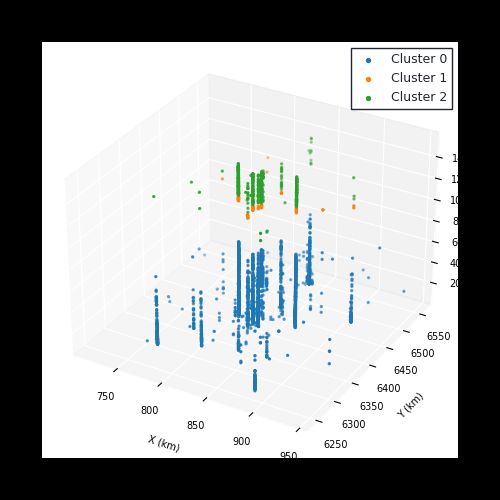

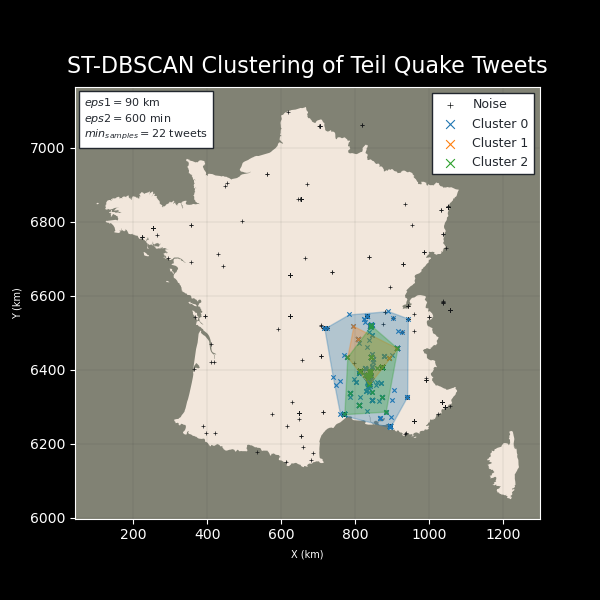

In [7]:
# Plot space time cube
plot_space_time_cube(tweets=tweets, eps1_terrain=eps1_terrain, eps2=eps2)
plot_hulls(tweets=tweets, hulls=hulls, eps1_terrain=eps1_terrain, eps2=eps2, min_samples=min_samples)

In [8]:
# Export tweets to geojson
tweets.to_file(f'../data/tweets_stdbscan_eps1_{eps1_terrain / 1_000:.0f}_km_eps2_{int(eps2 / 60)}_min.geojson', driver='GeoJSON')

# Export hulls to geojson
hulls.to_file(f'../data/hulls_stdbscan_eps1_{eps1_terrain / 1_000:.0f}_km_eps2_{int(eps2 / 60)}_min.geojson', driver='GeoJSON')

> Made with ♥ by Léa, Romain and Salaheddine.